Script for debugging the PIF implementation

In [1]:
# individual path
import sys
sys.path.insert(0,"/analysis/fabiane/phd/patch_individual_filters/")
sys.path.insert(0,"/analysis/fabiane/phd/nitorch/")

Imports

In [2]:
%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import h5py

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.nn.modules.module import Module

# sklearn functions
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold

# load functions from nitorch
from nitorch.data import load_nifti
from nitorch.transforms import  ToTensor, SagittalTranslate, SagittalFlip, \
                                AxialTranslate, normalization_factors, Normalize, \
                                IntensityRescale
from nitorch.callbacks import EarlyStopping, ModelCheckpoint
from nitorch.trainer import Trainer
from nitorch.initialization import weights_init
from nitorch.metrics import balanced_accuracy, sensitivity, specificity
from nitorch.utils import count_parameters

/home/fabiane/anaconda2/envs/mort1/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
from pif import PatchIndividualFilters3D

In [6]:
torch.__version__

'1.0.0'

In [7]:
# use multiple GPUs
gpu = 4
multi_gpus = None#[0, 1, 2]
b = 4
zero_one_normalize = False
zoom = 0.525

dtype = np.float64

In [8]:
# load mask
mask = None

In [9]:
train_h5 = h5py.File('/analysis/ritter/data/MS/CIS/train_dataset.h5', 'r')
holdout_h5 = h5py.File('/analysis/ritter/data/MS/CIS/holdout_dataset.h5', 'r')

In [10]:
X_holdout, y_holdout = holdout_h5['X'], holdout_h5['y']
X_train, y_train = train_h5['X'], train_h5['y']

In [11]:
# convert data to numpy arrays
#X_train = np.array(X_train, dtype=dtype)
#y_train = np.array(y_train)

#X_holdout = np.array(X_holdout, dtype=dtype)
#y_holdout = np.array(y_holdout)

In [12]:
class MSDataset(Dataset):
    def __init__(self, X, y, transform=None, target_transform=None, mask=None, z_factor=zoom, dtype=np.float32):
        self.X = np.copy(X)
        self.y = np.copy(y)
        self.transform = transform
        self.target_transform = target_transform
        self.mask = mask
        self.z_factor = zoom
        self.dtype = dtype
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx] >= 0.5
        label = torch.FloatTensor([label])
        
        # normalize by max
        image /= np.max(image)
        
        if self.transform:
            image = self.transform(image)
        #if self.target_transform:
        #    label = self.target_transform(label)
            
        sample = {"image" : image,
                 "label" : label}
                 #"idx":idx}
        return sample

In [13]:
if zero_one_normalize:
    intensity = IntensityRescale()
    ms_data_train = MSDataset(X_train, y_train, transform=transforms.Compose([intensity, ToTensor()]), mask=mask, dtype=dtype)
    ms_data_test = MSDataset(X_holdout, y_holdout, transform=transforms.Compose([intensity, ToTensor()]), mask=mask, dtype=dtype)
else:
    ms_data_train = MSDataset(X_train, y_train, transform=transforms.Compose([ToTensor()]), mask=mask, dtype=dtype)
    ms_data_test = MSDataset(X_holdout, y_holdout, transform=transforms.Compose([ToTensor()]), mask=mask, dtype=dtype)

In [14]:
sample = ms_data_train[29]
img = sample["image"]

In [15]:
img.shape

torch.Size([1, 96, 114, 96])

Text(0.5, 1.0, '1.0')

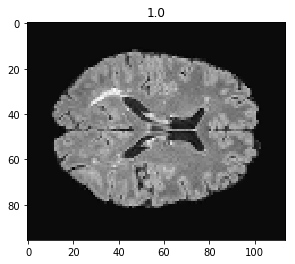

In [16]:
plt.imshow(img[0][:,:,46], cmap='gray')
plt.title(sample["label"].item())

# Define the classifier

In [21]:
class SixtyFourNet(nn.Module):
    def __init__(self, drp_rate=0.3):
        super(SixtyFourNet, self).__init__()
        self.drp_rate = drp_rate
        self.Conv_1 = nn.Conv3d(1, 64, kernel_size=3, stride=1, padding=0)
        self.pool_1 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_2 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.pool_2 = nn.MaxPool3d(kernel_size=3, stride=2, padding=0)
        self.Conv_3 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.Conv_4 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.pool_4 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)

        self.pif = PatchIndividualFilters3D([10,13,10],
                                            filter_shape=(3,3,3),
                                            #patch_shape=(5,5,5),
                                            patch_shape=(4,4,4),
                                            num_local_filter_in=64,
                                            num_local_filter_out=3,
                                            overlap=0,
                                            reassemble=False,
                                            debug=False)

        # 4, 64, 1, 2, 1
        self.classifier_scratch = nn.Sequential(
            nn.Linear(864, 100),
            nn.Linear(100, 1)
        )

    def encode(self, x, print_size=False):
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_1(x))
        h = F.dropout3d(self.pool_1(x), p=self.drp_rate)
        x = F.elu(self.Conv_2(h))
        if print_size:
            print(x.shape)
        h = F.dropout3d(self.pool_2(x), p=self.drp_rate)
        x = F.elu(self.Conv_3(h))
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_4(x))
        if print_size:
            print(x.shape)
        #h = F.dropout3d(self.pool_4(x), p=self.drp_rate)
        #if print_size:
        #    print(h.shape)
        
        h = self.pif(x)
        h = F.elu(h)
        if print_size:
            print(h.shape)
        return h.contiguous()

    def forward(self, x):
        print_size = False
        x = self.encode(x, print_size=print_size)
        x = self.flatten(x)
        x = self.classifier_scratch(x)
        return x
    
    def flatten(self, x):
        return x.view(x.size(0), -1)

In [22]:
if multi_gpus is None:
    net = SixtyFourNet().cuda(gpu)
else:
    net = torch.nn.DataParallel(SixtyFourNet(), device_ids=multi_gpus).cuda(gpu)

In [23]:
print("Trainable model parameters: {}".format(count_parameters(net)))

Trainable model parameters: 607093


In [24]:
net.forward(next(iter(ms_data_train))["image"].unsqueeze(0).cuda(gpu))

tensor([[-0.0934]], device='cuda:4', grad_fn=<AddmmBackward>)

# Training

In [25]:
def run(
    net,
    data,
    shape,
    callbacks=[],
    augmentations=[],
    masked=False,
    metrics=[],
    k_folds=None,
    b=4,
    num_epochs=35,
    retain_metric=None
):      

    #kf = StratifiedKFold(n_splits=k_folds, shuffle=True)
    #kf = KFold(n_splits=k_folds, shuffle=True)
    all_indices = list(range(len(data)))
    train_idx, val_idx = train_test_split(all_indices, test_size=0.1, random_state=12)
    fold_metric = []
    models = []
    fold = 0
    initial_prepend = None
    
    #for train_idx, val_idx in kf.split(data):#, df["label"]):
    for trial in range(10):
        print("Starting trial {}".format(trial))

        # add current fold number to model checkpoint path
        if callbacks is not None:
            for idx, callback in enumerate(callbacks):
                if isinstance(callback, ModelCheckpoint):
                    if initial_prepend is None:
                        initial_prepend = callbacks[idx].prepend
                    callbacks[idx].prepend = initial_prepend + "cv_fold_{}_".format(fold)
        fold += 1

        # restart model
        del net
        net = SixtyFourNet().cuda(gpu)
        
        # reset hyperparameters
        lr = 1e-4
        wd = 1e-4
        criterion = nn.BCEWithLogitsLoss().cuda(gpu)
        optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)

        train_sampler = SubsetRandomSampler(train_idx)
        val_sampler = SubsetRandomSampler(val_idx)
        print("Shuffled the data..")

        # Note: is the dataset loading necessary again?
        if zero_one_normalize:
            intensity = IntensityRescale()
            ms_data_train = MSDataset(X_train, y_train, transform=transforms.Compose([intensity, ToTensor()]), mask=mask, dtype=dtype)
        else:
            ms_data_train = MSDataset(X_train, y_train, transform=transforms.Compose([ToTensor()]), mask=mask, dtype=dtype)
        
        train_loader = DataLoader(
            ms_data_train, batch_size=b, num_workers=4, sampler=train_sampler
        )
        val_loader = DataLoader(
            ms_data_train, batch_size=1, num_workers=1, sampler=val_sampler
        )

        sample = next(iter(train_loader))
        img = sample["image"][0]
        lbl = sample["label"][0]
        print(img.shape)
        print(len(train_loader))
        plt.imshow(img.squeeze()[:,:,48], cmap='gray')
        plt.title(lbl.item())
        plt.show()
        trainer = Trainer(
            net,
            criterion,
            optimizer,
            metrics=metrics,
            callbacks=callbacks,
            device=gpu,
            #scheduler=sched,
        )
        # train model and store results
        net, report = trainer.train_model(
            train_loader,
            val_loader,
            num_epochs=num_epochs,
            show_train_steps=20,
            show_validation_epochs=1,
        )
        # append validation score of the retain metric
        if isinstance(retain_metric, str):
            fold_metric.append(report["val_metrics"][retain_metric][-1])
        else:
            fold_metric.append(report["val_metrics"][retain_metric.__name__][-1])

        models.append(net)
        print("Finished fold.")

        # visualize result
        trainer.visualize_training(report, metrics)
        trainer.evaluate_model(val_loader, gpu)

    print("################################")
    print("################################")
    print("All accuracies: {}".format(fold_metric))
    return fold_metric, models


In [26]:
num_epochs = 200
min_iters = 3
ignore_epochs = 5
normalize = False
retain_metric = balanced_accuracy
metrics = [accuracy_score, balanced_accuracy]

In [27]:
#r = 0

In [28]:
#output_dir = "/analysis/fabiane/models/MS/pretrained/from_keras/pytorch_finetuned/hdf5"
# ModelCheckpoint(path=output_dir,
                             #prepend="repeat_{}".format(r),
                             #store_best=True,
                             #ignore_before=ignore_epochs,
                             #retain_metric=retain_metric),

#augmentations = [SagittalFlip(), SagittalTranslate(dist=(-2, 3))]

In [29]:
callbacks = [EarlyStopping(patience=16, ignore_before=ignore_epochs, retain_metric="loss", mode='min')]
#callbacks = []

Starting trial 0
Shuffled the data..
torch.Size([1, 96, 114, 96])
28


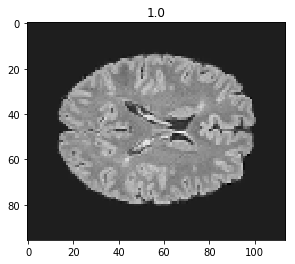

[0,    20] loss: 0.69433
Time elapsed: 0h:0m:4s
train accuracy_score: 50.45 %
train balanced_accuracy: 48.71 %
val accuracy_score: 46.15 %
val balanced_accuracy: 61.11 %
Val loss: 0.703427
[1,    20] loss: 0.69367
Time elapsed: 0h:0m:9s
train accuracy_score: 50.45 %
train balanced_accuracy: 52.71 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.712011
[2,    20] loss: 0.69215
Time elapsed: 0h:0m:14s
train accuracy_score: 53.15 %
train balanced_accuracy: 50.00 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.707852
[3,    20] loss: 0.69269
Time elapsed: 0h:0m:19s
train accuracy_score: 53.15 %
train balanced_accuracy: 50.00 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.698785
[4,    20] loss: 0.69286
Time elapsed: 0h:0m:24s
train accuracy_score: 54.95 %
train balanced_accuracy: 52.84 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.703501
[5,    20] loss: 0.69930
Time elapsed: 0h:0m:29s
tra

[43,    20] loss: 0.17161
Time elapsed: 0h:3m:43s
train accuracy_score: 96.40 %
train balanced_accuracy: 96.38 %
val accuracy_score: 84.62 %
val balanced_accuracy: 88.89 %
Val loss: 0.382151
[44,    20] loss: 0.11669
Time elapsed: 0h:3m:48s
train accuracy_score: 97.30 %
train balanced_accuracy: 97.46 %
val accuracy_score: 92.31 %
val balanced_accuracy: 94.44 %
Val loss: 0.153469
[45,    20] loss: 0.09107
Time elapsed: 0h:3m:54s
train accuracy_score: 98.20 %
train balanced_accuracy: 98.31 %
val accuracy_score: 92.31 %
val balanced_accuracy: 94.44 %
Val loss: 0.280045
[46,    20] loss: 0.07435
Time elapsed: 0h:3m:59s
train accuracy_score: 98.20 %
train balanced_accuracy: 98.31 %
val accuracy_score: 76.92 %
val balanced_accuracy: 83.33 %
Val loss: 0.587568
[47,    20] loss: 0.10492
Time elapsed: 0h:4m:4s
train accuracy_score: 97.30 %
train balanced_accuracy: 97.34 %
val accuracy_score: 92.31 %
val balanced_accuracy: 94.44 %
Val loss: 0.252905
[48,    20] loss: 0.04643
Time elapsed: 0h:4m:

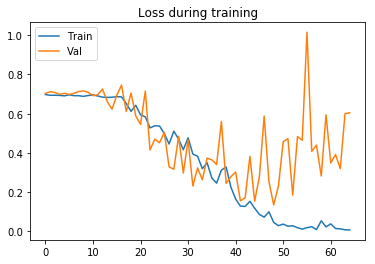

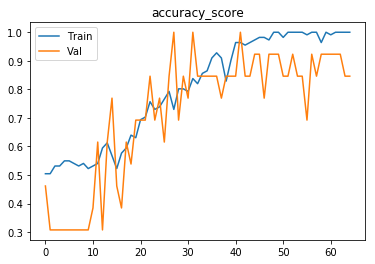

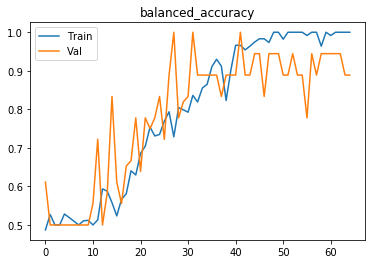

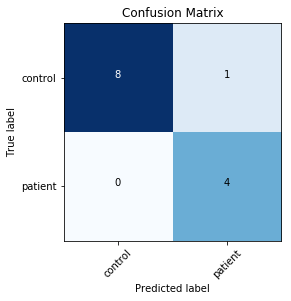

Starting trial 1
Shuffled the data..
torch.Size([1, 96, 114, 96])
28


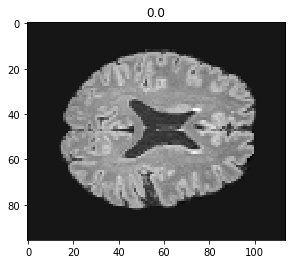

[0,    20] loss: 0.69740
Time elapsed: 0h:0m:4s
train accuracy_score: 53.15 %
train balanced_accuracy: 50.00 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.702544
[1,    20] loss: 0.69223
Time elapsed: 0h:0m:9s
train accuracy_score: 53.15 %
train balanced_accuracy: 50.00 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.715112
[2,    20] loss: 0.68728
Time elapsed: 0h:0m:14s
train accuracy_score: 53.15 %
train balanced_accuracy: 50.00 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.703686
[3,    20] loss: 0.69468
Time elapsed: 0h:0m:19s
train accuracy_score: 47.75 %
train balanced_accuracy: 46.40 %
val accuracy_score: 30.77 %
val balanced_accuracy: 36.11 %
Val loss: 0.694680
[4,    20] loss: 0.68522
Time elapsed: 0h:0m:25s
train accuracy_score: 54.95 %
train balanced_accuracy: 52.04 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.731720
[5,    20] loss: 0.69125
Time elapsed: 0h:0m:30s
tra

[43,    20] loss: 0.01114
Time elapsed: 0h:3m:45s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
val accuracy_score: 92.31 %
val balanced_accuracy: 94.44 %
Val loss: 0.639426
[44,    20] loss: 0.01060
Time elapsed: 0h:3m:50s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
val accuracy_score: 92.31 %
val balanced_accuracy: 94.44 %
Val loss: 0.359692
[45,    20] loss: 0.00622
Time elapsed: 0h:3m:55s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
val accuracy_score: 92.31 %
val balanced_accuracy: 94.44 %
Val loss: 0.459578
[46,    20] loss: 0.00662
Time elapsed: 0h:4m:0s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
val accuracy_score: 92.31 %
val balanced_accuracy: 94.44 %
Val loss: 0.793176
[47,    20] loss: 0.00270
Time elapsed: 0h:4m:5s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
val accuracy_score: 92.31 %
val balanced_accuracy: 94.44 %
Val loss: 0.533860
[48,    20] loss: 0.00262
Time elapse

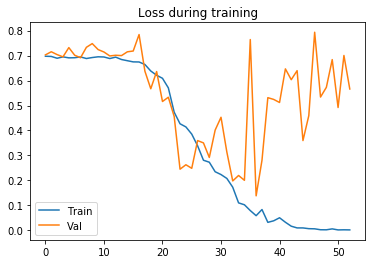

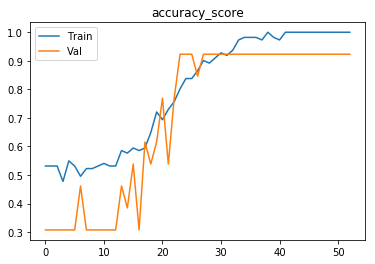

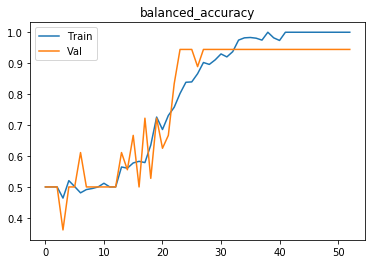

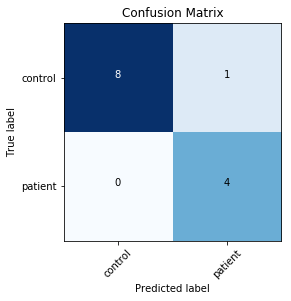

Starting trial 2
Shuffled the data..
torch.Size([1, 96, 114, 96])
28


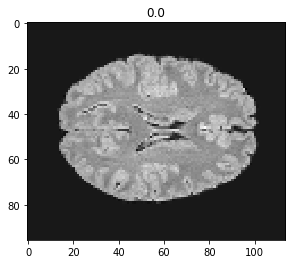

[0,    20] loss: 0.69138
Time elapsed: 0h:0m:4s
train accuracy_score: 48.65 %
train balanced_accuracy: 47.82 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.720996
[1,    20] loss: 0.69583
Time elapsed: 0h:0m:9s
train accuracy_score: 52.25 %
train balanced_accuracy: 50.07 %
val accuracy_score: 46.15 %
val balanced_accuracy: 33.33 %
Val loss: 0.693472
[2,    20] loss: 0.70075
Time elapsed: 0h:0m:14s
train accuracy_score: 46.85 %
train balanced_accuracy: 45.09 %
val accuracy_score: 76.92 %
val balanced_accuracy: 62.50 %
Val loss: 0.685171
[3,    20] loss: 0.69390
Time elapsed: 0h:0m:19s
train accuracy_score: 41.44 %
train balanced_accuracy: 42.86 %
val accuracy_score: 76.92 %
val balanced_accuracy: 83.33 %
Val loss: 0.686603
[4,    20] loss: 0.69076
Time elapsed: 0h:0m:25s
train accuracy_score: 55.86 %
train balanced_accuracy: 53.91 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.718092
[5,    20] loss: 0.69577
Time elapsed: 0h:0m:30s
tra

[43,    20] loss: 0.10238
Time elapsed: 0h:3m:45s
train accuracy_score: 93.69 %
train balanced_accuracy: 93.73 %
val accuracy_score: 76.92 %
val balanced_accuracy: 83.33 %
Val loss: 0.832069
[44,    20] loss: 0.13271
Time elapsed: 0h:3m:50s
train accuracy_score: 96.40 %
train balanced_accuracy: 96.50 %
val accuracy_score: 84.62 %
val balanced_accuracy: 81.94 %
Val loss: 0.433534
[45,    20] loss: 0.11372
Time elapsed: 0h:3m:55s
train accuracy_score: 97.30 %
train balanced_accuracy: 97.46 %
val accuracy_score: 69.23 %
val balanced_accuracy: 70.83 %
Val loss: 0.708604
[46,    20] loss: 0.05296
Time elapsed: 0h:4m:0s
train accuracy_score: 97.30 %
train balanced_accuracy: 97.34 %
val accuracy_score: 69.23 %
val balanced_accuracy: 70.83 %
Val loss: 0.805891
[47,    20] loss: 0.10932
Time elapsed: 0h:4m:5s
train accuracy_score: 95.50 %
train balanced_accuracy: 95.42 %
val accuracy_score: 84.62 %
val balanced_accuracy: 75.00 %
Val loss: 0.524343
[48,    20] loss: 0.07904
Time elapsed: 0h:4m:1

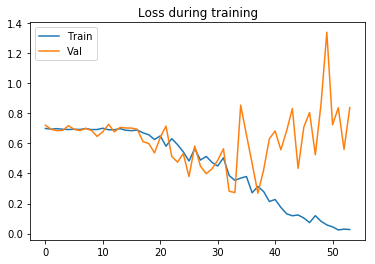

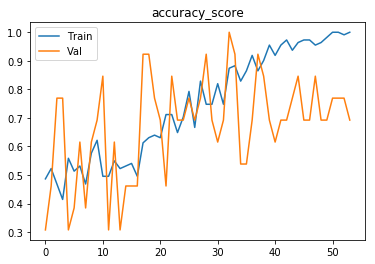

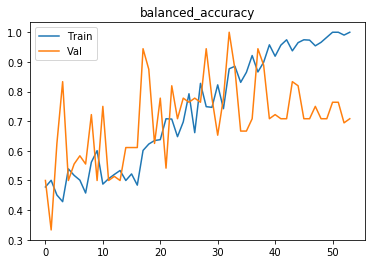

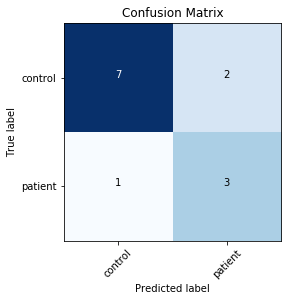

Starting trial 3
Shuffled the data..
torch.Size([1, 96, 114, 96])
28


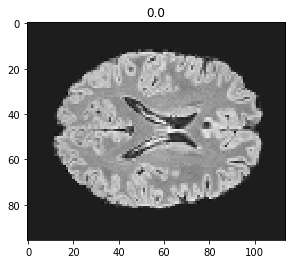

[0,    20] loss: 0.69327
Time elapsed: 0h:0m:4s
train accuracy_score: 52.25 %
train balanced_accuracy: 49.49 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.717145
[1,    20] loss: 0.69385
Time elapsed: 0h:0m:9s
train accuracy_score: 54.05 %
train balanced_accuracy: 52.33 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.714258
[2,    20] loss: 0.69674
Time elapsed: 0h:0m:14s
train accuracy_score: 53.15 %
train balanced_accuracy: 50.00 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.708902
[3,    20] loss: 0.68690
Time elapsed: 0h:0m:19s
train accuracy_score: 53.15 %
train balanced_accuracy: 50.00 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.722979
[4,    20] loss: 0.69377
Time elapsed: 0h:0m:24s
train accuracy_score: 53.15 %
train balanced_accuracy: 50.00 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.706894
[5,    20] loss: 0.69338
Time elapsed: 0h:0m:29s
tra

[43,    20] loss: 0.07298
Time elapsed: 0h:3m:45s
train accuracy_score: 99.10 %
train balanced_accuracy: 99.15 %
val accuracy_score: 76.92 %
val balanced_accuracy: 83.33 %
Val loss: 0.338508
[44,    20] loss: 0.06064
Time elapsed: 0h:3m:50s
train accuracy_score: 99.10 %
train balanced_accuracy: 99.15 %
val accuracy_score: 84.62 %
val balanced_accuracy: 88.89 %
Val loss: 0.389667
[45,    20] loss: 0.05303
Time elapsed: 0h:3m:55s
train accuracy_score: 99.10 %
train balanced_accuracy: 99.15 %
val accuracy_score: 76.92 %
val balanced_accuracy: 83.33 %
Val loss: 0.644684
[46,    20] loss: 0.09663
Time elapsed: 0h:4m:0s
train accuracy_score: 96.40 %
train balanced_accuracy: 96.27 %
val accuracy_score: 76.92 %
val balanced_accuracy: 83.33 %
Val loss: 0.787500
[47,    20] loss: 0.06871
Time elapsed: 0h:4m:5s
train accuracy_score: 98.20 %
train balanced_accuracy: 98.31 %
val accuracy_score: 76.92 %
val balanced_accuracy: 83.33 %
Val loss: 0.253354
[48,    20] loss: 0.03928
Time elapsed: 0h:4m:1

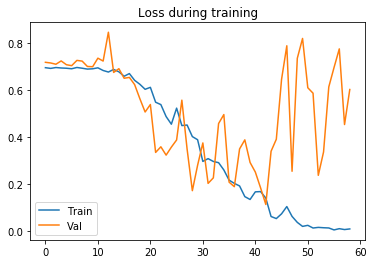

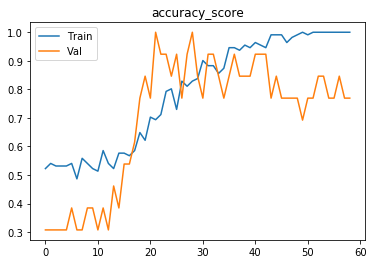

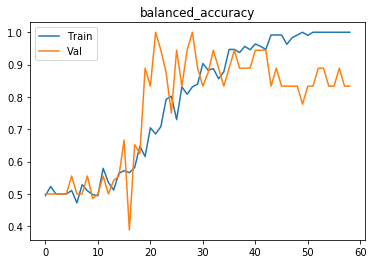

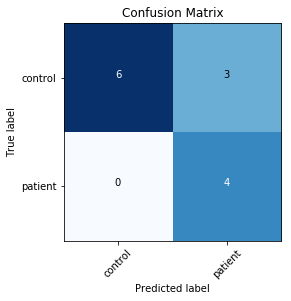

Starting trial 4
Shuffled the data..
torch.Size([1, 96, 114, 96])
28


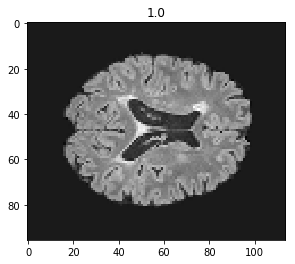

[0,    20] loss: 0.69360
Time elapsed: 0h:0m:4s
train accuracy_score: 46.85 %
train balanced_accuracy: 44.41 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.702169
[1,    20] loss: 0.69060
Time elapsed: 0h:0m:9s
train accuracy_score: 53.15 %
train balanced_accuracy: 50.00 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.720228
[2,    20] loss: 0.69371
Time elapsed: 0h:0m:14s
train accuracy_score: 52.25 %
train balanced_accuracy: 49.72 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.706566
[3,    20] loss: 0.68746
Time elapsed: 0h:0m:19s
train accuracy_score: 52.25 %
train balanced_accuracy: 49.38 %
val accuracy_score: 30.77 %
val balanced_accuracy: 43.06 %
Val loss: 0.741202
[4,    20] loss: 0.70669
Time elapsed: 0h:0m:24s
train accuracy_score: 45.95 %
train balanced_accuracy: 44.82 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.716294
[5,    20] loss: 0.69303
Time elapsed: 0h:0m:29s
tra

KeyboardInterrupt: 

In [30]:
fold_metric, models = run(net=net, data=ms_data_train,
                  k_folds=-1,
                  callbacks=callbacks,
                  shape=-1,
                  masked=False,
                  metrics=metrics,
                  num_epochs=num_epochs,
                  retain_metric=retain_metric,
                  b=b
                 )

print(np.mean(fold_metric))
print(np.std(fold_metric))

In [ ]:
5/0

# Start inference

In [ ]:
test_loader = DataLoader(
            ms_data_test, batch_size=1, num_workers=1, shuffle=False
)

In [ ]:
metrics = []
lr = 1e-5
wd = 1e-3
criterion = nn.BCEWithLogitsLoss().cuda(gpu)
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
    
for fold, model in enumerate(models):
    print("Fold {}".format(fold))

    all_preds = []
    all_labels = []
    
    net = model.cuda(gpu)
    net.eval()
    with torch.no_grad():
        for sample in test_loader:
            img = sample["image"]
            label = sample["label"]

            img = img.to(torch.device("cuda:" + str(gpu)))

            output = net.forward(img)
            pred = torch.sigmoid(output) >= 0.5
            all_preds.append(pred.cpu().numpy().item())
            all_labels.append(label.numpy().item())
    
    #print(all_preds)
    #print(all_labels)
    balanced_acc = balanced_accuracy(all_labels, all_preds)
    print(balanced_acc)
    '''trainer = Trainer(
                net,
                criterion,
                optimizer,
                scheduler=None,
                metrics=metrics,
                callbacks=None,
                device=gpu,
                prediction_type="binary"
            )
    computed_metrics = trainer.evaluate_model(test_loader, metrics=[balanced_accuracy])'''
    net.train()
    metrics.append(balanced_acc)
print("######## Final results ########")
metrics_df = pd.DataFrame(metrics)
print(metrics_df)
print("Balanced accuracy mean {:.2f} %".format(np.mean(metrics_df[0])*100))


In [ ]:

# load holdout set
df = pd.read_csv(doc_dir)
df = df.loc[indices_holdout]

metrics = []
callbacks = []

criterion = nn.BCEWithLogitsLoss().cuda(gpu)
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=0)

if zero_one_normalize:
    test_transforms = transforms.Compose([intensity, ToTensor()])
else:
    test_transforms = transforms.Compose([ToTensor()])
    
cis_data_test = CISDataset(X_holdout, y_holdout, transform=test_transforms, mask=mask, dtype=dtype)
test_loader = DataLoader(
    cis_data_test, batch_size=4, num_workers=2, shuffle=True
        )

In [ ]:
cis_data[4]["image"].dtype

In [ ]:
next(iter(test_loader))["image"].dtype

In [ ]:
model_dirs = [os.path.join(output_dir, "repeat_0_cv_fold_6_training_epoch_28_FINAL.h5"),
os.path.join(output_dir, "repeat_0_cv_fold_5_training_epoch_87_FINAL.h5"),
os.path.join(output_dir, "repeat_0_cv_fold_4_training_epoch_30_FINAL.h5"),
os.path.join(output_dir, "repeat_0_cv_fold_3_training_epoch_40_FINAL.h5"),
os.path.join(output_dir, "repeat_0_cv_fold_2_training_epoch_30_FINAL.h5"),
os.path.join(output_dir, "repeat_0_cv_fold_1_training_epoch_25_FINAL.h5"),
os.path.join(output_dir, "repeat_0_cv_fold_0_training_epoch_32_FINAL.h5")]

In [ ]:
model_dirs = [os.path.join(output_dir,"repeat_0_cv_fold_{}_BEST_ITERATION.h5".format(i)) for i in range(7)]
metrics = []
for fold, model_dir in enumerate(model_dirs):
    print("Fold {}".format(fold))
    
    # load pre-trained model
    #net = SixtyFourNet().cuda(gpu)
    net = serialize_model(net, model_dir)

    trainer = Trainer(
                net,
                criterion,
                optimizer,
                scheduler=None,
                metrics=metrics,
                callbacks=None,
                device=gpu,
                prediction_type="binary"
            )
    computed_metrics = trainer.evaluate_model(test_loader, metrics=[balanced_accuracy])
    
    metrics.append(computed_metrics)
print("######## Final results ########")
metrics_df = pd.DataFrame(metrics)
print(metrics_df)
print("Balanced accuracy mean {:.2f} %".format(np.mean(metrics_df["balanced_accuracy"])*100))


In [ ]:
for i, m in enumerate(models):
    print(i)
    for param in m.parameters():
        print(param.grad.norm(2))

In [ ]:
all_weight_norms = {}
all_bias_norms = {}
for i, m in enumerate(models):
    bias_norms = {}
    weight_norms = {}
    print(i)
    for name, param in m.named_parameters():
        #norms.append(param.grad.norm(2))
        norm = param.grad.norm(2)
        if name.endswith("bias"):
            name = name.replace(".bias", "")
            bias_norms["layer_{}".format(name)] = norm
        elif name.endswith("weight"):
            name = name.replace(".weight", "")
            weight_norms["layer_{}".format(name)] = norm
    all_weight_norms["fold_{}".format(i)] = weight_norms
    all_bias_norms["fold_{}".format(i)] = bias_norms

In [ ]:
list(metrics_df["balanced_accuracy"])

In [ ]:
num_cols = 2
num_rows = 4
plt.figure()
c = 1
r = 1

plt.figure(figsize=(12, 24))
plt.subplots_adjust(hspace=0.9, wspace=0.2)
for f in range(len(models)):
    plt.subplot(num_rows, num_cols, f+1)
    plt.plot(*zip(*sorted(all_weight_norms["fold_{}".format(f)].items())))
    plt.plot(*zip(*sorted(all_bias_norms["fold_{}".format(f)].items())))
    plt.legend(["Weights", "Biases"])
    plt.title("Fold {} Test balanced acc {:.2f}".format(f, metrics_df["balanced_accuracy"][f]))
    plt.xticks(rotation=90)
    axes = plt.gca()
    axes.set_ylim([0, 1])
    c += 1
plt.show()
    